> ## Get that Avo Toast.  
***It's not like you can afford a home in the Bay anyway.***

#### I love avocado toasts. But I also want to move out of my parents' basement.   
According to Australian millionnaire Tim Gurner, avocado toasts are the reason millenials cannot afford a home. But avocado prices vary greatly across regions. What if I lived in a city where avocados are cheap? Would I be able to save up for a house?

# Introduction
------
This project contains three parts:  
1. EDA of avocado prices across US    
2. Time series forecasting with fbrophet and LSTM   
3. Examination of avocado and housing. Do you really have to give up on avo toast? 

## 1. EDA

 The data is taken from the [Avocado Prices dataset](https://www.kaggle.com/neuromusic/avocado-prices) on Kaggle.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/avocado.csv')
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Dropping the Unnamed:0 column because it's useless.

In [3]:
df = df.drop(['Unnamed: 0'], 1)

Converting date to datetime type.

In [4]:
df['Date']=pd.to_datetime(df['Date'], format="%Y/%m/%d")

Plotting a general graph to see the average price distribution.

Text(0.5, 1.0, 'Average Price')

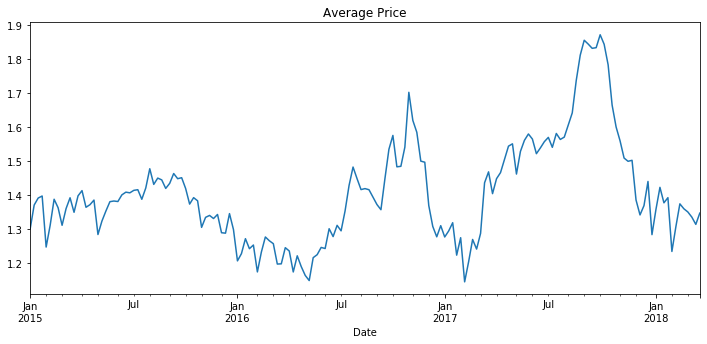

In [6]:
dategroup=df.groupby('Date').mean()
plt.figure(figsize=(12,5))
dategroup['AveragePrice'].plot(x=df.Date)
plt.title('Average Price')

What about the region-specific average price?

Text(0.5, 1.0, 'Average Price per Type and Region')

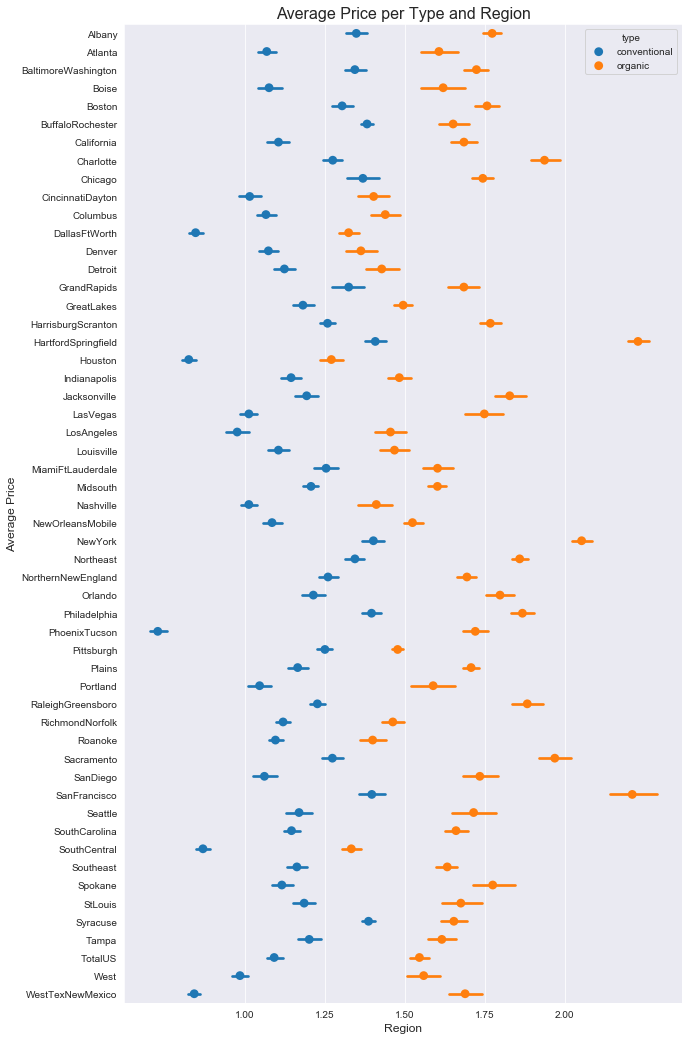

In [7]:
plt.figure(figsize=(10,18))
sns.set_style('darkgrid')
sns.pointplot(x='AveragePrice',y='region',data=df, hue='type',join=False)
plt.xticks(np.linspace(1,2,5))
plt.xlabel('Region',{'fontsize' : 'large'})
plt.ylabel('Average Price',{'fontsize':'large'})
plt.title("Average Price per Type and Region",{'fontsize':16})

In [140]:
regions = ['TotalUS', 'SanFrancisco']
mask = (
    df['region'].isin(regions)
    & (df['type']=='conventional')
    & (df['year']<2018)
)

In [141]:
df['Month'] = df['Date'].dt.month
df[mask].tail()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month
8367,2017-01-29,0.96,11.154911,10.862895,9.458043,7.406281,12.773754,13.048255,11.254430,6.555875,conventional,2017,TotalUS,1
8368,2017-01-22,0.94,11.956085,11.036874,11.558735,8.242764,12.700173,12.437926,13.021359,3.830177,conventional,2017,TotalUS,1
8369,2017-01-15,0.98,10.842733,9.995498,10.240545,5.178680,12.080504,12.414832,10.594311,3.728779,conventional,2017,TotalUS,1
8370,2017-01-08,0.99,10.771591,9.104454,11.263119,4.803864,11.766631,12.263859,9.747205,4.280623,conventional,2017,TotalUS,1
8371,2017-01-01,0.89,11.011905,9.814493,11.549034,4.904144,11.337419,11.216040,11.265697,3.607609,conventional,2017,TotalUS,1


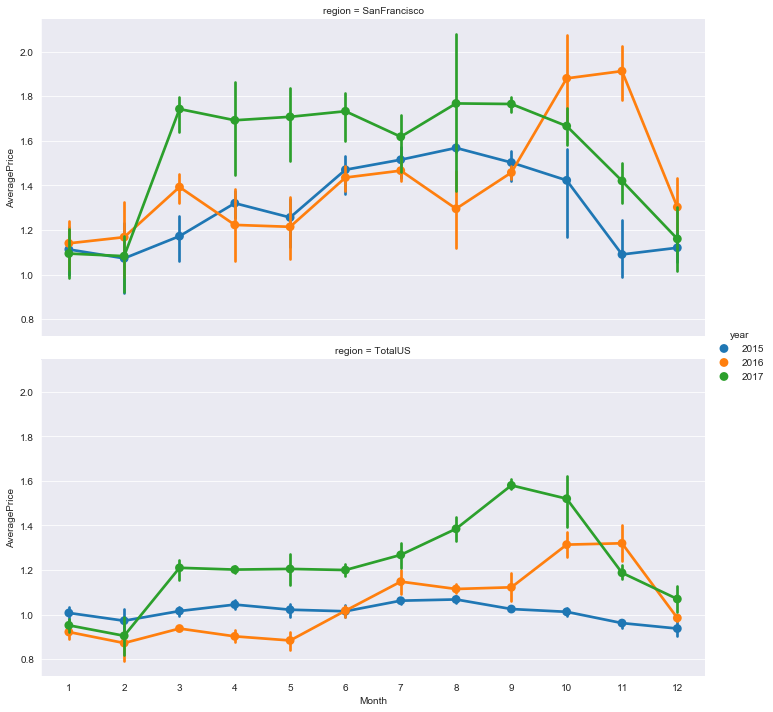

In [146]:
g = sns.catplot('Month','AveragePrice',data=df[mask],
               hue='year',
               row='region',
                kind='point',
               aspect=2,
              )

It seems like 2017 was a bad year for avo toast lovers. A quick Google search revealed that there was indeed a drought in California and Mexico in 2017, which contributed to raising avocado prices to a historical high.  

There seems to be some seasonal variability to avocado prices as well, with the price rising in the second half of the year. However, more data is needed to confirm this hypothesis.

## 2. Time series forecasting
### Approach 1: fbprophet

I recently found out about fbprophet, and wanted to try it out in this case to predict the future price of avocado. I wanted to include multiple features (region, type) in addition to the date, but it turns out that fbprophet only deals with univariate time series data - it makes predictions based on the date feature only. Not so cool since I would like to see the prediction based on a specific region and type. But for now, let's just forecast for the **average US** price for **conventional** avocados.

In [37]:
df2=pd.read_csv('data/avocado.csv')

In [38]:
from fbprophet import Prophet
%matplotlib inline

In [39]:
df2=df.loc[np.logical_and(df.region=="TotalUS",df.type=="conventional"),:]
w_df=df.loc[:,["Date","AveragePrice"]]
w_df.columns=["ds","y"]
w_df=w_df.sort_values("ds").reset_index(drop=True)
w_df.head()

,ds,y
0,2015-01-04,1.75
1,2015-01-04,1.49
2,2015-01-04,1.68
3,2015-01-04,1.52
4,2015-01-04,1.64


In [40]:
P=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, changepoint_range=1) 
#interval_width sets the uncertainty interval to produce a confidence interval around the forecast

P.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

P.fit(w_df)

future = P.make_future_dataframe(365)  
future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
18609,2019-03-21
18610,2019-03-22
18611,2019-03-23
18612,2019-03-24
18613,2019-03-25


In [ ]:
forecast = P.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
from fbprophet.plot import add_changepoints_to_plot
#fig = P.plot(forecast)
#a = add_changepoints_to_plot(fig.gca(), P, forecast)

For some reason my plot isn't showing in Jupyter Notebook, but it works fine on Kaggle. Here is the result from my Kaggle kernel.

## Approach 2: LSTM
fbprophet was pretty easy to use. However, I didn't feel like I had grasped what the model was doing. The entire process was almost foolproof. I feel like a more "old-school" model would give me more practice in dealing with time series data. Since I've never worked with LSTM, I thought that this would be my chance to learn it.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [69]:
df3=pd.read_csv('data/avocado.csv')

At first I made the same forecast as I did with fbprophet: region = totalUS, and type = conventional. However, I did not obtain good results because the dataset was too small. So here I will only present my successful attempt, which is by taking the average price across all regions, for both types of avocados.  

So I will drop all the columns except AveragePrice.

In [70]:
df3 = df3.drop(['Unnamed: 0','Date','Total Volume','4046','4225','4770','Total Bags','Small Bags','Large Bags','XLarge Bags','type','year', 'region'], 1)

Turning pd frame into array.

In [71]:
df3 = df3.T
df3 = df3.values

In [72]:
df3 = df3[0]

In [77]:
X_=[]
y_=[]

for i in range(10, len(df3)): #Using 10 past dates to predict the 11th date's price.
    X_.append(df3[i-10:i])
    y_.append(df3[i])
    j = int(len(df3)*0.9)
X_train, X_test, y_train, y_test = np.array(X_[:j]), np.array(X_[j:]), np.array(y_[:j]), np.array(y_[j:])

In [78]:
X_train, X_test = X_train.reshape((len(X_train), 10, 1)), X_test.reshape((len(X_test), 10, 1))

In [79]:
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout

In [80]:
model = Sequential()
model.add(LSTM(256,input_shape=(10,1)))
model.add(Dense(5))
#model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [81]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test),shuffle=False)

Train on 16424 samples, validate on 1815 samples
Epoch 1/10
16424/16424 [==============================] - 13s 774us/step - loss: 0.0379 - val_loss: 0.0409
Epoch 2/10
16424/16424 [==============================] - 11s 679us/step - loss: 0.0271 - val_loss: 0.0383
Epoch 3/10
16424/16424 [==============================] - 12s 720us/step - loss: 0.0266 - val_loss: 0.0382
Epoch 4/10
16424/16424 [==============================] - 13s 789us/step - loss: 0.0267 - val_loss: 0.0382
Epoch 5/10
16424/16424 [==============================] - 14s 835us/step - loss: 0.0266 - val_loss: 0.0383
Epoch 6/10
16424/16424 [==============================] - 13s 783us/step - loss: 0.0267 - val_loss: 0.0383
Epoch 7/10
16424/16424 [==============================] - 14s 825us/step - loss: 0.0266 - val_loss: 0.0384
Epoch 8/10
16424/16424 [==============================] - 13s 798us/step - loss: 0.0265 - val_loss: 0.0384
Epoch 9/10
16424/16424 [==============================] - 13s 774us/step - loss: 0.0265 - val_l

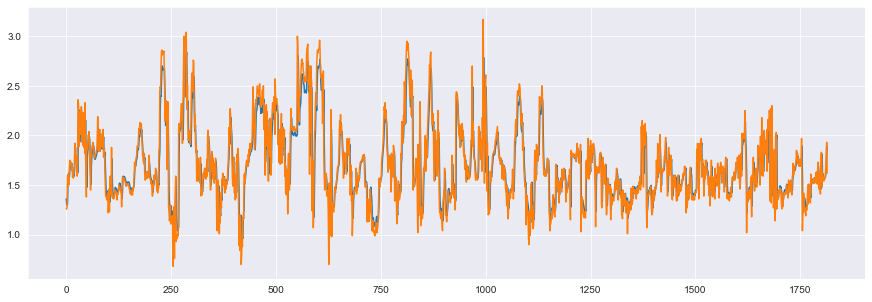

In [84]:
predicted_x = model.predict(X_test)
plt.figure(figsize=(15,5))
plt.plot(predicted_x)
plt.plot(y_test.reshape(-1,1))

The model is looking good. But it's quite useless right now. I want to use it to predict future values! 

In [85]:
def take_step(step):
    next_step = model.predict(step)
    next_step = next_step.reshape(1,1,1)
    next_step = np.concatenate(([step[0][1:]],next_step),axis=1)
    return next_step, next_step[0][0][0]

In [86]:
step = np.array([X_test[0]])

In [88]:
res = take_step(step)
print(res[1])

2.06


Now I have a functional model that can predict forward avocado prices. I still want to build a model that can take into consideration multiple features like region and type. My end goal is to build an API that predicts the price of avocado based on user's input for region, type, and date. But I'm stuck at how to do all that with one single model. I *could* build 54 models, one for each region, but I'm sure there is a better way. While I continue to research on this, I will pickle this simple model in case I want to use it later. 

In [ ]:
import pickle
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

## 3. Avocado & Housing

Now to the fun part! How many avocados would I have to give up in order to move out of my parents' basement?

I found the median home-price for US cities [here](https://www.kiplinger.com/tool/real-estate/T010-S003-home-prices-in-100-top-u-s-metro-areas/index.php). Home-price data is as of December 31, 2018.

In [90]:
from plotnine import *

In [91]:
hp = pd.read_csv('data/Homeprice.csv')

In [92]:
hp.head()

,City,HomePrice
0,Albany,135000
1,Atlanta,210000
2,Boise,260000
3,Boston,410000
4,Charlotte,204000


In [98]:
avo_avg_price = df.AveragePrice.mean()
print(avo_avg_price)

1.405978409775878


Assuming that I'm buying one avocado per day at the market's average price, how many years would I need to go avocado-free in order to afford a house?

In [114]:
years_supply = hp.HomePrice/(avo_avg_price*365)
hp['Years'] = years_supply
hp.head()

,City,HomePrice,Years
0,Albany,135000,263.064504
1,Atlanta,210000,409.211451
2,Boise,260000,506.642749
3,Boston,410000,798.936643
4,Charlotte,204000,397.519696


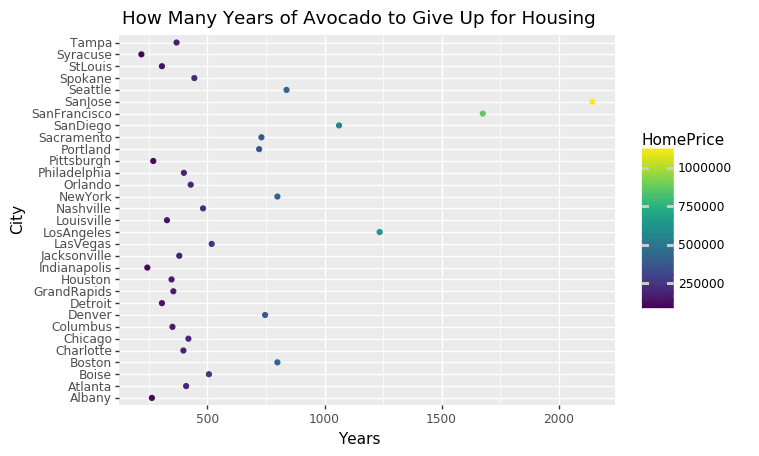

<ggplot: (128532011300)>

In [118]:
ggplot(hp, aes(x='Years', y='City', color='HomePrice')) + geom_point() + \
ggtitle("How Many Years of Avocado to Give Up for Housing")

Well. San Francisco and San Jose happened to be my two favorite cities. I would need respectively 1675 and 2143 years of supplies of avocado in order to afford a home in these places. Since I'm unlikely to live that long even with future technologies, I don't have to make the choice between avocado and housing. That's wonderful -  I can finally order my avo toasts, guilt-free.